# **Observations**

---

### **About the results**
- CNN performance drops as images are shifted from the center, indicating limited translation invariance.
- Accuracy and loss show smooth, symmetric degradation with some irregular patterns.

---

### **Performance Area**
- Accuracy remains high (>80%) within about ±10–12 pixels of translation in both x and y directions.
- Performance drops significantly beyond this range.

---

### **Irregularities**
- Some outer regions show loss decreasing again, possibly due to:
  - Zero-padding effects creating uniform patterns.
  - The model defaulting to common fallback predictions.
- These irregularities may be artifacts rather than meaningful model behavior.

---

### **Identical behavior**
- Slight asymmetry observed; vertical (y-axis) translations reduce accuracy more than horizontal ones.
- Could be due to dataset structure or learned model biases.

---

### **Issues with this evaluation method**
- Zero-padding during translation introduces unnatural borders..
- Only translation is tested; scale and rotation effects are not covered.
- CIFAR dataset might have a center bias, making the model more fragile to shifts.

---



In [ ]:
from time import perf_counter

import torch
import numpy as np
from matplotlib import pyplot as plt

from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms.v2 import ToTensor, RandomCrop, RandomHorizontalFlip, Compose, CenterCrop, RandomAffine, ColorJitter
from torchvision.transforms.v2.functional import affine

In [ ]:
train_transforms = [ToTensor()]
test_transforms = [ToTensor()]

flip = True
rotation = 15
scale = (0.8, 1.2)
color = (0.95, 1.05)
crop = 30

if color is not None:
    train_transforms.append(ColorJitter(color, color, color, (color[0]-1, color[1]-1)))  # brightness, contrast, saturation, hue
if rotation > 0 or scale is not None:
    train_transforms.append(RandomAffine(rotation, scale=scale))
if flip:
    train_transforms.append(RandomHorizontalFlip())
if crop < 32:
    train_transforms.append(RandomCrop(crop))
    test_transforms.append(CenterCrop(crop))

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [ ]:
train_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=Compose(train_transforms))

test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=Compose(test_transforms))

100%|██████████| 170M/170M [00:12<00:00, 13.1MB/s]


In [ ]:
batch_size = 128

# Create data loaders.
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True,
                              num_workers=32)
test_dataloader = DataLoader(test_data, batch_size=batch_size,
                             num_workers=32)

for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Shape of X [N, C, H, W]: torch.Size([128, 3, 30, 30])
Shape of y: torch.Size([128]) torch.int64


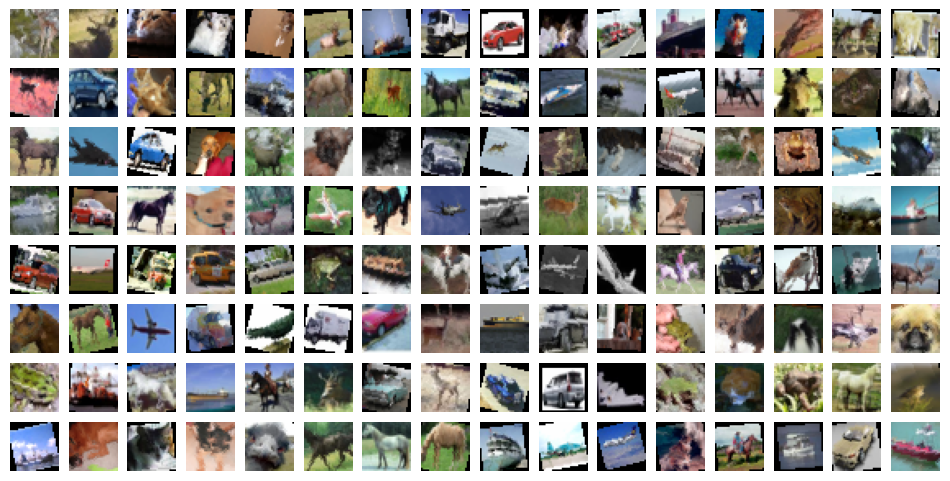

In [ ]:
# look at some of the augmented images
for X, _ in train_dataloader:
    plt.figure(figsize=(12, 6))
    for ind, img in enumerate(X):
        plt.subplot(8, 16, ind+1)
        plt.imshow(img.permute((1, 2, 0)))
        plt.axis("off")
    plt.show()
    break

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


def conv_layer(previous_filters, current_filters, kernel_size):
    return nn.Sequential(nn.Conv2d(previous_filters, current_filters, kernel_size, padding="same"),
                         nn.BatchNorm2d(current_filters),
                         nn.Mish())


def vgg_level(n_layers, prev_filters, current_filters, kernel_size):
    level = nn.Sequential()
    for layer_ind in range(n_layers):
        level.append(conv_layer(prev_filters if layer_ind == 0 else current_filters, current_filters, kernel_size))
    level.append(nn.MaxPool2d(2, ceil_mode=True))
    return level


def vgg_body(n_levels, layers_per_level, start_filters, kernel_size, input_channels=3, filter_multiplier=2):
    body = nn.Sequential()
    current_filters = start_filters
    previous_filters = input_channels

    for level_ind in range(n_levels):
        body.append(vgg_level(layers_per_level, previous_filters, current_filters, kernel_size))
        previous_filters = current_filters
        current_filters *= 2
    return body


def hidden_linear(dim):
    layer = nn.Sequential(nn.LazyLinear(dim),
                          nn.BatchNorm1d(dim),
                          nn.Mish())
    return layer


n_levels = 4
layers_per_level = 3
start_filters = 64
kernel_size = 3
linear_dim = 1024

model = nn.Sequential()
model.append(vgg_body(n_levels, layers_per_level, start_filters, kernel_size))
model.append(nn.Flatten())
model.append(hidden_linear(linear_dim))
model.append(nn.Linear(linear_dim, 10))

# for reference: this is what a "flat" model construction could look like
# rather than using nested functions
#prev_filters = 3
#current_filters = start_filters
#for level_ind in range(n_levels):
    #for layer_ind in range(layers_per_level):
    #    model.append(conv_layer(prev_filters, current_filters, kernel_size))
        #model.append(nn.Conv2d(prev_filters, current_filters, kernel_size, padding="same"))
        #model.append(nn.BatchNorm2d(current_filters))
        #model.append(nn.Mish())
    #    prev_filters = current_filters
    #model.append(vgg_level(layers_per_level, prev_filters, current_filters, kernel_size))

    #model.append(nn.MaxPool2d(2, ceil_mode=True))
    #prev_filters = current_filters
    #current_filters *= 2

#model.append(nn.Flatten())
#model.append(nn.LazyLinear(linear_dim))
#model.append(nn.BatchNorm1d(linear_dim))
#model.append(nn.GELU())

model = model.to(device)
with torch.no_grad():
    model(next(iter(train_dataloader))[0].to(device))
print(model)


def glorot_init(layer: nn.Module):
    if isinstance(layer, nn.Linear):
        nn.init.xavier_uniform_(layer.weight)
        nn.init.zeros_(layer.bias)


#with torch.no_grad():
#    model.apply(glorot_init)


def accuracy(labels: torch.tensor,
             outputs: torch.tensor) -> torch.tensor:
    predictions = torch.argmax(outputs, axis=-1)
    matches = labels == predictions
    return matches.float().mean()

Using cuda device
Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
      (1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
      (2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (1): Sequential(
      (0): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, 

In [ ]:
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = torch.optim.AdamW(model.parameters(), weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=3)

In [ ]:
class EarlyStopping:
    def __init__(self, model, patience, direction="min", min_delta=0.0001, verbose=False):
        if direction not in ["min", "max"]:
            raise ValueError("direction should be 'min' or 'max', you passed {}".format(direction))
        self.best_state_dict = {key: None for key in model.state_dict()}
        self.best_value = np.inf if direction == "min" else -np.inf
        self.direction = direction
        self.min_delta = min_delta
        self.model = model

        self.patience = patience
        self.disappointment = 0
        self.verbose = verbose

    def update(self, value):
        if ((self.direction == "min" and value < self.best_value - self.min_delta)
            or (self.direction == "max" and value > self.best_value + self.min_delta)):
            self.best_value = value
            for key in model.state_dict():
                self.best_state_dict[key] = model.state_dict()[key].clone()
            self.disappointment = 0
            if self.verbose:
                print("New best value found; no longer disappointed")
            return 0
        else:
            self.disappointment += 1
            if self.verbose:
                print("EarlyStopping disappointment increased to {}".format(self.disappointment))

            if self.disappointment > self.patience:
                if self.verbose:
                    print("EarlyStopping has become too disappointed; now would be a good time to cancel training")
                    print("Restoring best model from state_dict")
                self.model.load_state_dict(self.best_state_dict)
                return 1
            else:
                return 0

In [ ]:
def train_model(model: nn.Module,
                loss_fn: nn.Module,
                optimizer: torch.optim.Optimizer,
                scheduler: torch.optim.lr_scheduler.LRScheduler,
                training_loader: DataLoader,
                validation_loader: DataLoader,
                n_epochs: int,
                verbose: bool = True):
    n_training_examples = len(training_loader.dataset)
    batches_per_epoch = n_training_examples // training_loader.batch_size
    print("Running {} epochs at {} steps per epoch.".format(n_epochs, batches_per_epoch))

    # note, for training we only track the average over the epoch.
    # this is somewhat imprecise, as the model changes over the epoch.
    # so the metrics at the end of the epoch will usually be better than at the start,
    # but we average over everything.
    # we could record train metrics more often to get a better picture of training progress.
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    early_stopper = EarlyStopping(model, patience=9, verbose=verbose)

    for epoch in range(n_epochs):
        if verbose:
            print("Starting epoch {}...".format(epoch + 1), end=" ")

        start_time = perf_counter()
        epoch_train_losses = []
        epoch_train_accuracies = []

        model.train()
        for batch_ind, (input_batch, label_batch) in enumerate(training_loader):
            batch_loss, batch_accuracy = train_step(input_batch, label_batch, model, loss_fn, optimizer)
            epoch_train_losses.append(batch_loss.item())
            epoch_train_accuracies.append(batch_accuracy.item())

        end_time = perf_counter()
        time_taken = end_time - start_time

        # evaluate after each epoch
        val_loss, val_accuracy = evaluate(model, validation_loader, loss_fn)
        scheduler.step(val_loss)

        should_stop = early_stopper.update(val_loss)

        val_losses.append(val_loss.item())
        val_accuracies.append(val_accuracy.item())
        train_losses.append(np.mean(epoch_train_losses))
        train_accuracies.append(np.mean(epoch_train_accuracies))

        if verbose:
            print("Time taken: {} seconds".format(time_taken))
            print("\tTrain/val loss: {} / {}".format(train_losses[-1], val_losses[-1]))
            print("\tTrain/val accuracy: {} / {}".format(train_accuracies[-1], val_accuracies[-1]))
            print("\tLR is now {}".format(scheduler.get_last_lr()[0]))

        if should_stop:
            print("Early stopping...")
            break

    return {"train_loss": np.array(train_losses), "train_accuracy": np.array(train_accuracies),
            "val_loss": np.array(val_losses), "val_accuracy": np.array(val_accuracies)}


def train_step(input_batch, label_batch, model, loss_fn, optimizer):
    input_batch = input_batch.to(device)
    label_batch = label_batch.to(device)
    output_batch = model(input_batch)
    batch_loss = loss_fn(output_batch, label_batch)

    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    with torch.no_grad():
        batch_accuracy = accuracy(label_batch, output_batch)
    return batch_loss, batch_accuracy


def evaluate(model, dataloader, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss, correct = 0, 0

    with torch.no_grad():
        for input_batch, label_batch in dataloader:
            input_batch = input_batch.to(device)
            label_batch = label_batch.to(device)
            predictions = model(input_batch)
            val_loss += loss_fn(predictions, label_batch)
            correct += (predictions.argmax(axis=1) == label_batch).type(torch.float).sum()

        val_loss /= num_batches
        val_accuracy = correct / size
    return val_loss, val_accuracy

def evaluate_with_translation(model, dataloader, loss_fn, translate_x, translate_y):
        model.eval()
        size = len(dataloader.dataset)
        num_batches = len(dataloader)
        val_loss, correct = 0, 0

        with torch.no_grad():
            for input_batch, label_batch in dataloader:
                input_batch = input_batch.to(device)
                input_batch = affine(input_batch, angle=0, scale=1, shear=0., translate=[translate_x, translate_y])
                label_batch = label_batch.to(device)
                predictions = model(input_batch)
                val_loss += loss_fn(predictions, label_batch).item()
                correct += (predictions.argmax(1) == label_batch).type(torch.float).sum().item()

        val_loss /= num_batches
        correct /= size
        return val_loss, correct

In [ ]:
# uncomment if you want to train yourself
#metrics = train_model(model, loss_fn, optimizer, scheduler, train_dataloader, test_dataloader,
#                      n_epochs=200)

In [ ]:
# uncomment if you want to load the checkpoint instead
model.load_state_dict(torch.load("/04_cifar_model.pt", weights_only=True))

<All keys matched successfully>

In [ ]:
import numpy as np

translate_x_range = range(-32, 33, 2)
translate_y_range = range(-32, 33, 2)

losses = np.zeros((len(translate_x_range), len(translate_y_range)))
accuracies = np.zeros((len(translate_x_range), len(translate_y_range)))

for i, translate_x in enumerate(translate_x_range):
    for j, translate_y in enumerate(translate_y_range):
        loss, accuracy = evaluate_with_translation(model, test_dataloader, loss_fn, translate_x, translate_y)
        losses[i, j] = loss
        accuracies[i, j] = accuracy

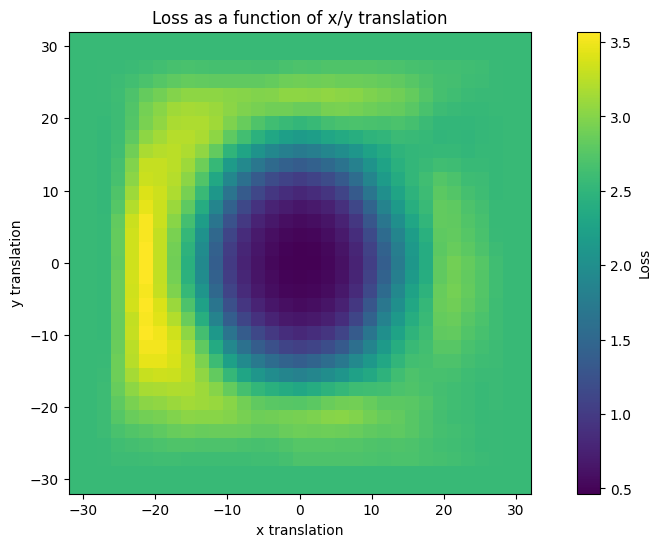

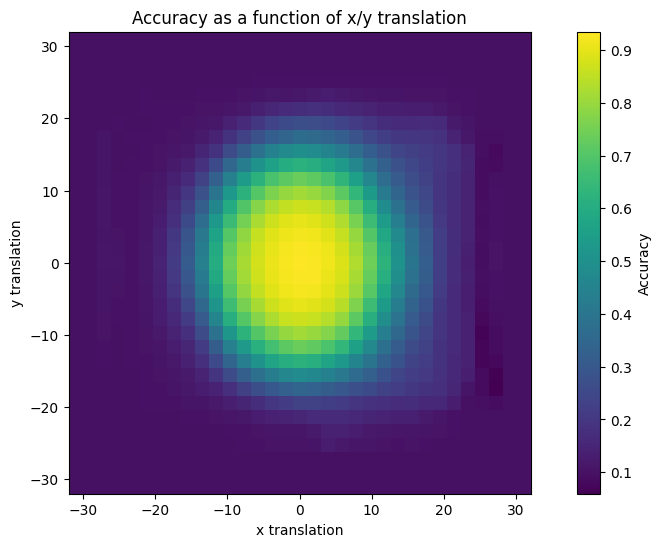

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.imshow(losses, extent=[translate_x_range[0], translate_x_range[-1], translate_y_range[0], translate_y_range[-1]], origin='lower', cmap='viridis')
plt.colorbar(label='Loss')
plt.title('Loss as a function of x/y translation')
plt.xlabel('x translation')
plt.ylabel('y translation')
plt.show()

plt.figure(figsize=(12, 6))
plt.imshow(accuracies, extent=[translate_x_range[0], translate_x_range[-1], translate_y_range[0], translate_y_range[-1]], origin='lower', cmap='viridis')
plt.colorbar(label='Accuracy')
plt.title('Accuracy as a function of x/y translation')
plt.xlabel('x translation')
plt.ylabel('y translation')
plt.show()

In [ ]:
# if you loaded the checkpoint, it should be 93.49% accuracy!
evaluate(model, test_dataloader, loss_fn)

(tensor(0.4642, device='cuda:0'), tensor(0.9349, device='cuda:0'))

In [ ]:
# only run this if you trained yourself, duh
plt.plot(metrics["train_loss"], label="train")
plt.plot(metrics["val_loss"], label="validation")
plt.legend()
plt.title("Loss")
plt.xlabel("Epoch")
plt.show()

plt.plot(metrics["train_accuracy"], label="train")
plt.plot(metrics["val_accuracy"], label="validation")
plt.legend()
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [ ]:
classes = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

for X, y in test_dataloader:
    with torch.no_grad():
        probabilities = torch.nn.functional.softmax(model(X.to(device)), dim=1)
        predictions = probabilities.argmax(axis=1)

    plt.figure(figsize=(12, 12))
    for ind, img in enumerate(X[:36]):
        pred_here = predictions[ind]
        prob_here = probabilities[ind, pred_here].item()
        true_here = y[ind]

        plt.subplot(6, 6, ind+1)
        plt.imshow(img.permute((1, 2, 0)))
        plt.axis("off")

        plt.title("true: {} pred: {}\nprob: {:.3f}".format(classes[true_here], classes[pred_here], prob_here),
                  fontsize=8)
    plt.show()
    break

In [ ]:
from torchvision.transforms.v2.functional import affine


# showcase of the affine transform: Useful if you want to do option 1 of the assignment
translate_x = 6
translate_y = -8
for X, _ in test_dataloader:
    X = affine(X, angle=0, scale=1, shear=0., translate=[translate_x, translate_y])
    plt.figure(figsize=(12, 6))
    for ind, img in enumerate(X):
        plt.subplot(8, 16, ind+1)
        plt.imshow(img.permute((1, 2, 0)))
        plt.axis("off")
    plt.show()
    break

In [ ]:
# showcase of how one might iterate over several submodules and apply them one-by-one.
# useful for option 2.
# of course you want to find a more programmatic way of doing this, e.g. with loops


conv_body = model[0]
dummy_inp = torch.zeros(1, 3, crop, crop).to(device)
features = dummy_inp

features = conv_body[0][0](features)
#plot(features)
features = conv_body[0][1](features)
#plot(features)
# ...
features = conv_body[1][0](features)
#plot(features)
# etc.
